In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
print("a")

In [2]:
from src.exploration.eda import *

## Loading Data

In [4]:
# mapping from id to emoji
mapping = pk.load(open(MAPPING_PATH, 'rb'))
# mapping from emoji to id
inv_map = {v: k for k, v in mapping.items()}

In [5]:
phraseVecModel = Phrase2Vec.from_word2vec_paths(300, W2V_PATH, E2V_PATH)
e2v = phraseVecModel.emojiVecModel
w2v = phraseVecModel.wordVecModel

## Emojis Descriptions Coherency

<div class="alert alert-success">
In order to assess whether the used features space is meaningful, we compute a dispersion metric across the multiple descriptions present for a single emoji.
</div>

In [8]:
desc_words_df = get_desc_emojis_df(phraseVecModel)

desc_words_df

,desc,em,vec
0,ballot box with check,☑️,"[-0.21191406, 0.17572021, -0.57836914, 0.16699..."
1,full moon with face,🌝,"[0.21972656, 0.22265625, 0.2253418, 0.26757812..."
2,cheese,🌝,"[-0.28515625, 0.076171875, 0.041259766, 0.5195..."
3,moon,🌝,"[-0.03857422, 0.18945312, 0.20605469, 0.171875..."
4,smiling moon,🌝,"[0.08154297, 0.359375, 0.31933594, 0.31054688,..."
...,...,...,...
6083,electric bus,🚎,"[0.28100586, 0.01171875, 0.17944336, -0.197021..."
6084,transportation,🚎,"[0.02746582, -0.11425781, -0.011474609, 0.0854..."
6085,transport,🚎,"[0.0119018555, -0.016357422, -0.010925293, 0.0..."
6086,trolleybus,🚎,"[0.055664062, -0.011474609, 0.119140625, 0.341..."


In [10]:
grouped_desc_df = gather_descs_vecs(desc_words_df,inv_map)

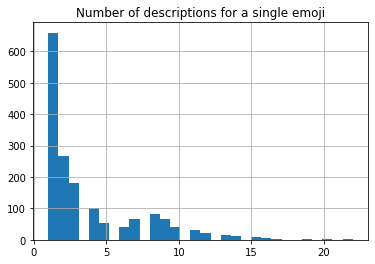

In [11]:
plot_num_desc_per_emoji(grouped_desc_df)

In [12]:
N = grouped_desc_df.shape[0]
N_1 = grouped_desc_df[grouped_desc_df.length ==1].shape[0]
print(f"Proportion of emojis with a single description: {N_1/N*100:.2f} %")

Proportion of emojis with a single description: 39.67 %


In [13]:
grouped_desc_df['dispersion'] = grouped_desc_df['vec'].apply(dispersion)

In [14]:
em_coherency_df = (grouped_desc_df[grouped_desc_df.dispersion > 0]
                                  .sort_values('dispersion'))

### Most coherent emojis

In [15]:
best_emojis = em_coherency_df.head(5)
display_emoji_desc(best_emojis)

🇨🇽 (disp=0.03)
	flag for christmas island
	christmas island flag
🇳🇷 (disp=0.03)
	flag for nauru
	nauruan flag
🇳🇫 (disp=0.03)
	flag for norfolk island
	norfolk island flag
🇮🇴 (disp=0.03)
	flag for british indian ocean territory
	british indian ocean territory flag
🈺 (disp=0.04)
	営
	work


### Least Coherent Emojis

TODO:
* correlation matrixes between the subspaces of the vectors of the words in the description
* try tfidf and stopwords removal
* valuable information provided users

First analyze the crowdsourcing output (dispersion for each emoji among humans)
CORRELATION MATRIX ==> det == spread + ?random noise

In [16]:
worst_emojis = em_coherency_df.tail(5).iloc[::-1]
display_emoji_desc(worst_emojis)

🔂 (disp=0.26)
	clockwise rightwards and leftwards open circle arrows with circled one overlay
	loop once symbol
	circle arrows with number 1
🇨🇻 (disp=0.24)
	flag for cape verde
	regional indicator symbol letters cv
🔁 (disp=0.24)
	clockwise rightwards and leftwards open circle arrows
	loop symbol
🔛 (disp=0.23)
	on with exclamation mark with left right arrow above
	on
🇻🇮 (disp=0.23)
	regional indicator symbol letters vi
	us virgin islander flag


<div class="alert alert-success">
The "worst emojis" rows seems to indicate that long descriptions don't always show an addition-friendly behavior: indeed, the semantic sense of each word added could land anywhere in the feature space. <br>
    
Instead, using a method based on **crowdsourcing** coupled with a **tf-idf** selection could lead to better results.
</div>

<AxesSubplot:>

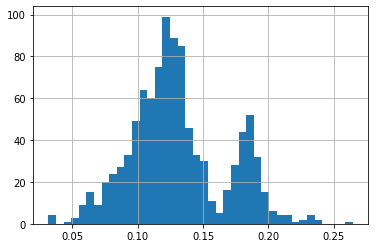

In [17]:
em_coherency_df.dispersion.hist(bins=40)

<div class="alert alert-success"> 
TODO : find the origin of this bimodal distribution
</div>

## Similarity with words

In [20]:
emoji_df = get_emoji_df(e2v,mapping)

face_emojis_df = emoji_df[emoji_df['em'].isin(emotions_faces)].copy()

face_emojis_df['top_sim10'] = face_emojis_df['em'].apply(lambda x:[i[0] for i in e2v.similar_by_word(x)])

In [23]:
face_emojis_df['top_sim5_faces'] = face_emojis_df['em'].apply(lambda em: get_10_faces(em,e2v))

In [24]:
face_emojis_df

,em,vec,top_sim10,top_sim5_faces
index,,,,
34,😕,"[0.093202256, 0.004986584, 0.036923353, 0.0547...","[😖, 😠, 😾, 😞, 😲, 😰, 😝, 🙎, 😨, 😁]","[😖, 😠, 😞, 😲, 😰]"
47,😡,"[0.10005704, 0.025081947, 0.09612578, 0.063638...","[😾, 😦, 💢, 🙎, 👺, 😳, 😏, 🙎🏾, 🤦, 😠]","[😦, 😳, 😏, 😠, 😧]"
55,🤒,"[0.05091751, 0.059580225, -0.032689758, 0.0636...","[🤢, 😷, 💫, 😓, 😵, 🙅🏾, 🙎🏾, 🙀, 😫, 🙎🏼]","[🤢, 😷, 😓, 😵, 😫]"
71,😮,"[-0.02114388, -0.05283045, 0.032437645, -0.023...","[👐🏿, 👐🏻, 👄, 🤐, 📬, 👐🏽, 👅, 🔒, 👐🏾, 😗]","[🤐, 😗, 😶, 😘, 🙄]"
79,😟,"[0.09861565, 0.08570119, 0.06212258, -0.085885...","[😨, 😞, 😓, 😠, 😭, 😔, 😰, 😢, 😒, 😹]","[😨, 😞, 😓, 😠, 😭]"
...,...,...,...,...
1236,😆,"[0.069521226, 0.017129565, 0.078695066, 0.0805...","[☺️, 😀, 😊, 😄, 😃, 😏, 😂, 😸, 😉, 😁]","[😀, 😊, 😄, 😃, 😏]"
1242,☹,"[0.07232274, 0.054626353, 0.07297801, -0.05746...","[🙎🏻, 🙎🏿, 💆🏻, 🙆🏻, 🙎🏼, 🙅🏻, 🙆🏿, 🐼, 👃🏻, 🙍🏿]","[😦, 😳, 😡, 😰, 😊]"
1288,🤔,"[0.059266087, -0.059827834, 0.05785582, 0.0562...","[💜, 👳, 🤥, 💮, 😏, 🙇🏻, 🙇🏾, 🙇🏿, 🈷️, 🧀]","[🤥, 😏, 😔, 😈, 😍]"


## T-SNE

<div class="alert alert-success">
T-sne results could be reproduced as in the emoji2vec paper.
</div>

<img src="../results/emojivec_eda/tsne/emojis_tsne.jpeg"></div>

<div class="alert alert-success">
Emotions Emojis were computed in order to check how the emotions behave in this feature space
</div>

<img src="../results/emojivec_eda/tsne/faces_tsne.jpeg"></div>